# Certamen 1: Machine Learning for Business Intelligence.

**Integrante:** Daniel Moreno Cartagena

**Profesor:** Rodrigo De La Fuente

## Instrucciones

1. Este certamen es de caracter individual, por lo tanto queda estrictamente prohibida la copia de codigo ajeno. **Cualquier copia será motivo de reprobación.**

2. En caso de elaborar su respuesta **basandose** en código ajeno encontrado en la web, debe agradecer al menos citando la referencia.

3. La fecha límite para la entrega de esta tarea queda establecida para el **02/07/2020 a la media noche**.

Nota: La resolución de algunos de los ejercicios puede tomar bastante tiempo, así como su ejecución. Por lo tanto se recomienda hacer la tarea con anticipación y evitar riesgos. Además, es **obligatorio el uso de Google Colab**.

In [ ]:
import tensorflow as tf
import IPython.display as display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import os
import random 
import cv2
import pathlib
import glob
import math, json, os, sys
import keras
import keras.backend as K
import itertools
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import logging
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
logging.getLogger("tensorflow").setLevel(logging.WARNING)

from keras.models import Model
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.applications import ResNet50
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.layers.pooling import AveragePooling2D, GlobalAveragePooling2D
from shutil import copyfile
from google.colab import drive
from PIL import Image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.utils import class_weight
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Pregunta 1 (y única).

La idea de este certamen es utilizar redes neuronales convolucionales para reproducir los resultados del reciente artículo [COVID-Net: A Tailored Deep Convolutional Neural Network Design for Detection of COVID-19 Cases from Chest X-Ray Images](https://arxiv.org/pdf/2003.09871.pdf) (L. Wang et al. 2020)

### Preprocesamiento (20 pts.)

Lo primero será crear un iterador que genere los batches con los cuales la red hara el forward y backward pass.
Recuerde que se cuenta con dos archivos .txt que contienen las rutas y etiquetas de nuestros datos. Por lo tanto nuestro iterador tiene ciertos objetivos generales:

1. Leer el archivo .txt
2. Abrir la imagen y guardarla como una matriz. Almacenar también la etiqueta respectiva para cada imagen.

In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks'
#data_dir = pathlib.Path(data_dir)

data_train = 'data/train'
data_test = 'data/test'

path_train = 'train_split_v3.txt'
path_test = 'test_split_v3.txt'

open_train_txt = os.path.join(data_dir, path_train)
open_test_txt = os.path.join(data_dir, path_test)

train = pd.read_csv(open_train_txt, sep = " ", header = None, names = ["num", "data", "label", "place"])
test = pd.read_csv(open_test_txt, sep = " ", header = None, names = ["num", "data", "label", "place"])                 

x_train = train['data']
y_train = train['label']

x_test = test['data']
y_test = test['label']

Para cada una de las imagenes:

1. Desecharemos el 15% superior de la imagen, pues contiene información poco relevante.
2. Recortaremos la imagen de tal forma de que nos quede una matriz cuadrada.
3. Redimensionaremos la matriz a tamaño (256x256)

Algo indeseable para una red neuronal es el sobreajuste (i.e. que la red se aprenda los datos y sea incapaz de generalizar a nuevos datos que provengan de la misma distribución). Para evitar el sobreajuste, haremos pequeñas transformaciones sobre nuestras imágenes de **entrenamiento**, lo cual hará que nuestra red vea con muy poca probabilidad exactamente el mismo dato más de una vez:

1. Haremos un "flip" (simetria axial) de la imagen en el eje horizontal con una probabilidad de (0.5).
2. Recortaremos la imagen de manera aleatoria, dejándola finalmente de tamaño 224x224.
3. Haremos traslaciones de la imagen en el eje vertical y horizontal de +-4 pixeles (muestreando el valor de la traslación desde de una distribución uniforme).

In [ ]:
#Dos de estas funciones fueron sacadas del paper de referencia.
#Cortar el 15% de la foto
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

#Deja la matriz cuadrada con respecto al minimo de fila o columas
def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

#Redimensionando la imagen
def red_image(img, dsize=(256, 256)):
  z = cv2.resize(img, dsize, interpolation=cv2.INTER_CUBIC)
  return z

#Hace el flip de la imagen con 0.5 de probabilidad
def random_flip(img, prob=0.5):
    if np.random.rand() >= prob:
      return img
    else:
      flip = cv2.flip(img, 0)
    return flip

#Hace un cortes aleatorios dejándo la imagen de tamaño 224x224
def random_crop(img, random_crop_size):
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx)]

#Traslaciones de +-4 pixeles
def tras_image(img):
  height = img.shape[0]
  width = img.shape[1]
  #Se pone -5 y +5, ya que asi el maximo valor redondeado es -4 o +4
  x1 = int(np.random.uniform(-5, 5))
  x2 = int(np.random.uniform(-5, 5))
  T = np.float32([[1, 0, x1], [0, 1, x2]])
  translation = cv2.warpAffine(img, T, (width, height))
  return translation

In [ ]:
#Funcion general para llamarla en ImageDataGenerator
def function_general(image):
  image = crop_top(image)
  image = central_crop(image)
  image = red_image(image)
  image = random_flip(image)
  image = random_crop(image, (224, 224))
  image = tras_image(image)
  return image

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,  preprocessing_function = function_general, validation_split=0.2)

In [ ]:
train_generator = datagen.flow_from_dataframe(dataframe = train, directory = os.path.join(data_dir, data_train), x_col = 'data', y_col = 'label', 
                                              class_mode = 'categorical', target_size = (224,224), batch_size = 64, subset='training')
validation_generator = datagen.flow_from_dataframe(dataframe = train, directory = os.path.join(data_dir, data_train), x_col = 'data', y_col = 'label', 
                                              class_mode = 'categorical', target_size = (224,224), batch_size = 64, subset='validation')

Found 11119 validated image filenames belonging to 3 classes.
Found 2779 validated image filenames belonging to 3 classes.


In [ ]:
train_data, train_label = train_generator.next()
print(train_data.shape, train_label.shape)

(64, 224, 224, 3) (64, 3)


Para las imagenes de testeo

Hacer un recorte del centro de la imagen, dejándola de tamaño 224x224

In [ ]:
def crop_center(img, cropx, cropy):
  x,y = img.shape[0], img.shape[1]
  startx = x//2-(cropx//2)
  starty = y//2-(cropy//2)    
  return img[starty:starty+cropy, startx:startx+cropx]

def red_img(img, dsize=(300, 300)):
  z = cv2.resize(img, dsize, interpolation=cv2.INTER_CUBIC)
  return z

def function_test(img):
  img = red_img(img)
  img = crop_center(img, 224, 224)
  return img

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255,  preprocessing_function = function_test)

In [ ]:
test_generator = test_datagen.flow_from_dataframe(dataframe = test, directory = os.path.join(data_dir, data_test), x_col = 'data', y_col = 'label', 
                                              class_mode = 'categorical', target_size = (224,224), batch_size = 64)

Found 1579 validated image filenames belonging to 3 classes.


In [ ]:
test_data, test_label = test_generator.next()
print(test_data.shape, test_label.shape)

(64, 224, 224, 3) (64, 3)


Finalmente, nuestro set de datos de entrenamiento se encuentra altamente desbalanceado. Para evitar que la red minimice su función de costos a través de la minimización de la clase más representativa, obteniendo mal rendimiento en el resto de las clases, se pide implementar una de estas dos soluciones:

1. Hacer que nuestro iterador genere por cada batch de datos una cantidad similar de datos por cada clase.
2. Pesar nuestra función de costos, añadiendo una penalización en caso de obtener mal rendimiento en las clases menos representadas.


**hint** Muchos de las transformaciones exigidas en este apartado se encuentran implementadas en Keras, TensorFlow, Pytorch.

In [ ]:
# Se implementara la solucion numero 2. 

# Esto, a traves del class_weight : índice de clase de asignación de diccionario (enteros) opcionales a un valor de peso (flotante), 
# utilizado para ponderar la función de pérdida (solo durante el entrenamiento).
# Esto se puede usar para equilibrar las clases sin volver a muestrear, o para entrenar un modelo que le da más importancia a una clase en particular.

# El cual se implementara en la parte del entrenamiento del modelo. 

### Verificación (5 pts.):

Muestre al menos 5 imágenes de cada uno de los conjuntos, asegurándose de que se cumple con lo establecido en el paso de preprocesamiento.

In [ ]:
CLASS_NAMES = np.array(['pneumonia', 'COVID-19', 'normal'])
CLASS_NAMES

array(['pneumonia', 'COVID-19', 'normal'], dtype='<U9')

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(20,20))
  for n in range(5):
      ax = plt.subplot(3,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


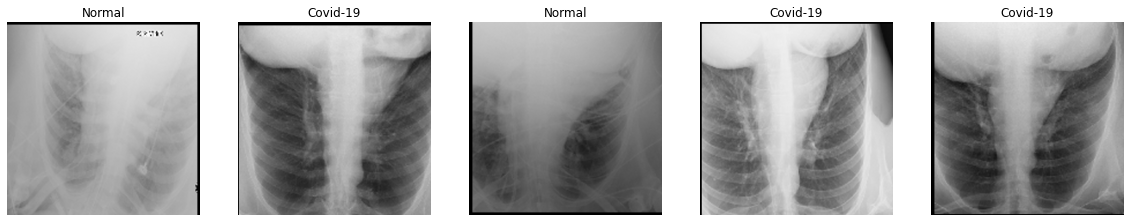

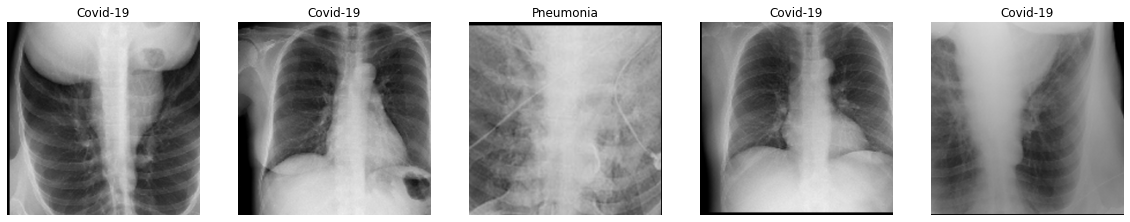

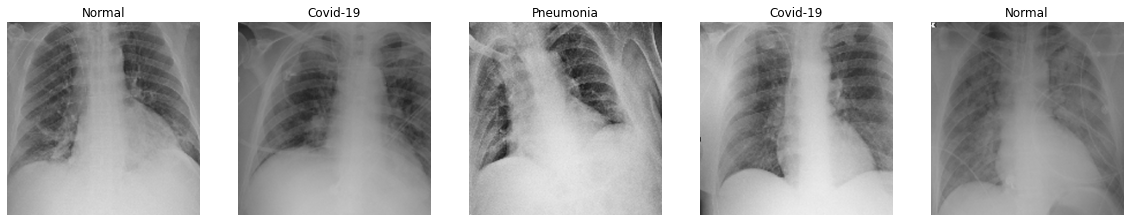

In [ ]:
train_data, train_label = next(train_generator)
show_batch(train_data, train_label)

val_data, val_label = next(validation_generator)
show_batch(val_data, val_label)

test_data, test_label = next(test_generator)
show_batch(test_data, test_label)

### Modelo (20 pts.)

Para entrenar nuestro algoritmo utilizaremos un famoso modelo llamado [ResNet](https://arxiv.org/abs/1512.03385) (He et al. 2015). El cual consistirá en un modelo que cuenta con 50 capas convolucionales residuales (ResNet50). 
Para obtener mejores resultados, en lugar de inicializar los pesos de manera aleatoria, se inicializarán utilizando los pesos de una red entrenada sobre [ImageNet](http://www.image-net.org/) (la competencia de clasificación de imágenes más famosa en visión computacional).
La capa de salida de esta arquitectura será reemplazada por una capa lineal de 3 nodos, con función de activación softmax, que nos dará la probabilidad para cada uno de nuestras clases.

Para entrenar este modelo:

1. Ocupe Adam como optimizador, utilizando un learning rate de 0.00001.
2. Reporte las métricas de accuracy y f1-score.
3. Ocupe como criterio de convergencia EarlyStopping (si la metrica f1-score macro no mejora durante más de 10 épocas sobre el conjunto de validación, entonces el entrenamiento debe detenerse).
4. Guarde los pesos del modelo entrenado sólo si éste presenta mejoras en la métrica de f1-score macro (medida sobre el conjunto de validación)


In [ ]:
#https://medium.com/@aakashgoel12/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d#:~:text=By%20default,%20f1%20score%20is,like%20accuracy,%20categorical%20accuracy%20etc

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
model = keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3), classes=1000)
avg_pool = GlobalAveragePooling2D()(model.output)
#flatten = Flatten()(model.output)
out = Dense(3, activation='softmax', name='output_layer')(avg_pool)
dnl_model = Model(inputs=model.input, outputs=out)
dnl_model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy', metrics=['accuracy', get_f1])

early_stopping = EarlyStopping(monitor='val_get_f1', patience=10, restore_best_weights=True)
checkpointer = ModelCheckpoint(os.path.join(data_dir,'resnet50_best1_Moreno.h5')) 

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
dnl_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
#https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), np.asarray(y_train))
bal_weights = dict(enumerate(class_weights))

In [ ]:
batch_size=64
num_train_steps = train_generator.samples//batch_size
num_valid_steps = validation_generator.samples//batch_size
history = dnl_model.fit_generator(train_generator, steps_per_epoch=num_train_steps, epochs=22, callbacks=[early_stopping, checkpointer], validation_data=validation_generator, 
                                  validation_steps=num_valid_steps, class_weight=bal_weights, workers=6)
dnl_model.save(os.path.join(data_dir,'resnet50_final1_Moreno.h5'))

Epoch 1/22
173/173 [==============================] - 495s 3s/step - loss: 0.3005 - accuracy: 0.8431 - get_f1: 0.8348 - val_loss: 2.0496 - val_accuracy: 0.0131 - val_get_f1: 0.0131
Epoch 2/22
173/173 [==============================] - 468s 3s/step - loss: 0.1682 - accuracy: 0.9066 - get_f1: 0.9065 - val_loss: 2.5206 - val_accuracy: 0.0125 - val_get_f1: 0.0124
Epoch 3/22
173/173 [==============================] - 469s 3s/step - loss: 0.1451 - accuracy: 0.9191 - get_f1: 0.9192 - val_loss: 2.3336 - val_accuracy: 0.0140 - val_get_f1: 0.0138
Epoch 4/22
173/173 [==============================] - 469s 3s/step - loss: 0.1302 - accuracy: 0.9276 - get_f1: 0.9275 - val_loss: 2.3835 - val_accuracy: 0.0140 - val_get_f1: 0.0133
Epoch 5/22
173/173 [==============================] - 469s 3s/step - loss: 0.1215 - accuracy: 0.9324 - get_f1: 0.9326 - val_loss: 1.1938 - val_accuracy: 0.4906 - val_get_f1: 0.4771
Epoch 6/22
173/173 [==============================] - 467s 3s/step - loss: 0.1121 - accuracy: 0

### Curvas de aprendizaje (5 pts.):

Muestre las curvas de aprendizaje obtenidas luego del entrenamiento, tanto para la función de costos como para las métricas exigidas.

In [ ]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'val_get_f1', 'loss', 'accuracy', 'get_f1'])


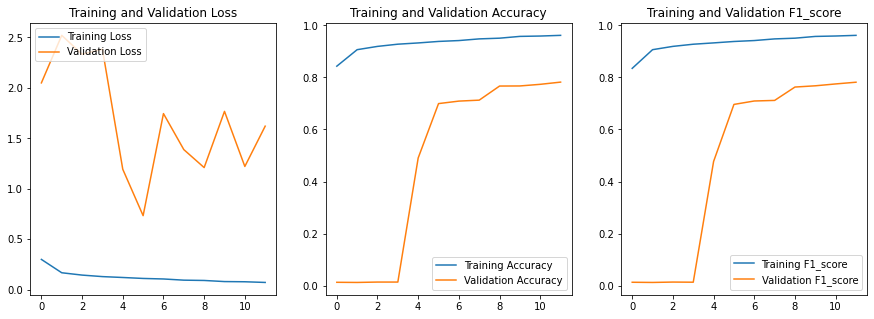

In [ ]:
#Curvas de aprendizaje
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

f1_score = history.history['get_f1']
val_f1_score = history.history['val_get_f1']

plt.figure(figsize=(15,5))

ax1 = plt.subplot(1, 3, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

ax1 = plt.subplot(1, 3, 2)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

ax1 = plt.subplot(1, 3, 3)
plt.plot(f1_score, label='Training F1_score')
plt.plot(val_f1_score, label='Validation F1_score')
plt.legend(loc='lower right')
plt.title('Training and Validation F1_score')

plt.show()

### Metrica final (10 pts.)

Muestre la matriz de confusión obtenida sobre los datos de test. Debería obtener algo como lo que se muestra a continuación.

In [ ]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
  
    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Evaluación en los datos del test
24/24 [==============================] - 32s 1s/step
loss, accuracy, f1_score: [1.7655510902404785, 0.3717447817325592, 0.3717447519302368]
Confusion Matrix


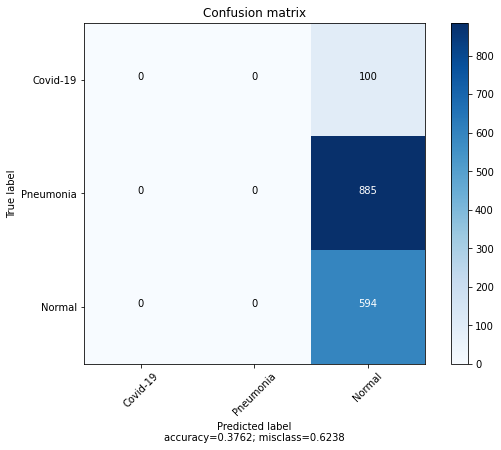

In [ ]:
# Evalua el modelo con los datos de test
num_test_steps = test_generator.samples//batch_size
print("Evaluación en los datos del test")
results = dnl_model.evaluate(test_generator, steps=num_test_steps)
print("loss, accuracy, f1_score:", results)

# Confution Matrix and Classification Report
Y_pred = dnl_model.predict_generator(test_generator, test_generator.samples//batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm_matrix = confusion_matrix(test_generator.classes, y_pred)
cm = plot_confusion_matrix(cm_matrix, ['Covid-19', 'Pneumonia', 'Normal'])

## BONUS (5 pts.):

Tanto en el paper como en esta implementación existe un error metodológico muy común, pero a la misma vez muy grave, el cual dice relación con los conjuntos de datos. Diga cuál es este error y porqué es importante corregirlo.

**Respuesta:**

El error metodologico comun que se comete en los problemas de clasificiacion en donde se tiene que etiquetar binarias o múltiples categorías (normal, neumonia y COVID-19) es el trabajar con un set de datos de entrenamiento desbalanceado entre las distintas clases. Dentro de esto se tiene que alguna clase es minoritaria, es decir, de la cual se tienen pocas muestras como es el caso del COVID-19 con 473 o mayoritaria como es el caso de la clase normal y neumonia con 7966 y 5459 en el set de entrenamiento respectivamente.

Este error es importante corregirlo porque los clasificadores de machine learning como Random Forests no lidian muy bien con datasets de entrenamiento desbalanceados ya que son sensibles a las proporciones de las diferentes clases. Como consecuencia, estos algoritmos tienden a favorecer la clase con la mayor proporción de observaciones, clase “mayoritaria”, lo cual puede derivar en métricas de exactitud sesgadas. Esto puede ser particularmente problemático cuando estamos interesados en la clasificación correcta de una clase minoritaria, ya que al trabajar con el dataset desbalanceado se encuentran altos valores de exactitud que son producto realmente de la clasificación correcta de la clase mayoritaria y por tanto son un reflejo de la distribución de clases subyacente.

En conclusion, por lo general afecta a los algoritmos en su proceso de generalización de la información y perjudicando a las clases minoritarias provocando una falsa sensación de que el modelo 
funciona bien porel sobre entrenamiento (overfitting) del modelo. 